In [1]:
!pip install yfinance

In [3]:
# Import yahoofinance and other libraries
import yfinance as yf
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Get the data for stock Facebook from 2017-04-01 to 2019-04-30
msft = yf.download('MSFT', start="2017-08-31", end="2020-09-03")
sp500 = yf.download('^GSPC', start="2017-08-31", end="2020-09-03")

# Print the first five rows of the data
sp500.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-27,3485.139893,3501.379883,3468.350098,3484.550049,3484.550049,3929560000
2020-08-28,3494.689941,3509.229980,3484.320068,3508.010010,3508.010010,3855880000
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000


In [4]:
#Save the data imported in directory
msft.to_csv('msft.csv')
sp500.to_csv('sp500.csv')

In [5]:
# Create new data frame. We extract and calculate the appropriate stock market data - Returns and price-
# data is the DataFrame of the trading model
data = pd.DataFrame(index = msft.index)
data['msft'] = msft['Adj Close'].shift(-1) - msft['Adj Close']
data['sp500'] = sp500['Adj Close'] - sp500['Adj Close'].shift(1)
data['msft_lag1'] = data['msft'].shift(1)
data['price_msft'] = msft['Adj Close']

data.head()

,msft,sp500,msft_lag1,price_msft
Date,,,,
2017-08-30,0.726738,NaN,NaN,70.769379
2017-08-31,-0.793663,14.059814,0.726738,71.496117
2017-09-01,-0.315552,4.900146,-0.793663,70.702454
2017-09-05,-0.200806,-18.699951,-0.315552,70.386902
2017-09-06,0.898834,7.689941,-0.200806,70.186096


In [6]:
# Data cleaning
data = data.fillna(method='ffill')
data = data.dropna()
data.isnull().sum()

msft          0
sp500         0
msft_lag1     0
price_msft    0
dtype: int64

In [7]:
data.to_csv('data.csv')

In [8]:
data.shape

(757, 4)

In [9]:
#Split the data into train and test sets
train = data.iloc[-700:-350, :]
test = data.iloc[-350:, :]
print(train.shape, test.shape)

(350, 4) (350, 4)


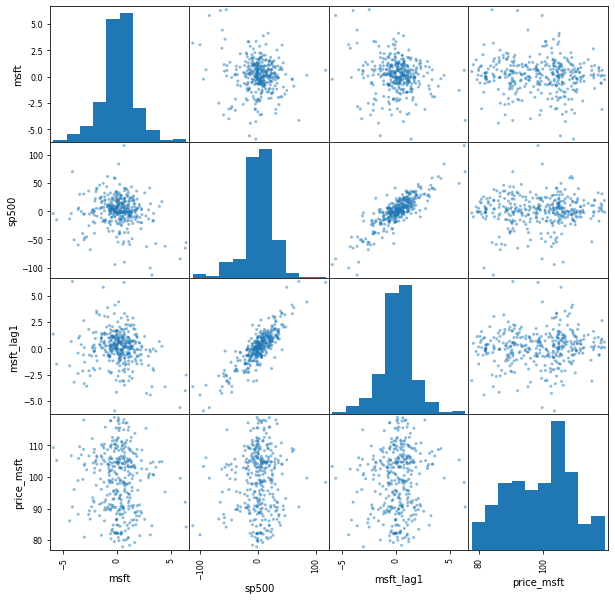

In [10]:
#initial data visualization to observe association
from pandas.plotting  import scatter_matrix
sm = scatter_matrix(train, figsize = (10,10))

train.iloc[: :-1].corr()['msft']

In [11]:
#Create Ordinary Least Squares model
formula = 'msft~sp500+msft_lag1'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   msft   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.455
Date:                Tue, 03 Nov 2020   Prob (F-statistic):            0.00465
Time:                        17:58:09   Log-Likelihood:                -658.19
No. Observations:                 350   AIC:                             1322.
Df Residuals:                     347   BIC:                             1334.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1292      0.085      1.512      0.132      -0.039       0.297
sp500          0.0009      0.006      0.153      0.879      -0.011       0.013
msft_lag1     -0.1872      0.099     -1.885      0.060      -0.382       0.008
==============================================================================
Omnibus:                       27.120   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.192
Skew:                          -0.364   Prob(JB):                     6.98e-15
Kurtosis:                       4.985   Cond. No.                         31.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

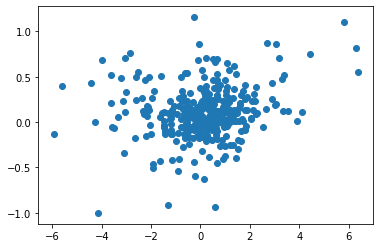

In [12]:
train['predictY'] = lm.predict(train)
test['predictY'] = lm.predict(test)

plt.scatter(train['msft'], train['predictY'])

In [13]:
#Define AdjustedMetric Function to calculate the Adjusted R2 and Root Mean Square Error
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE


#Define assessTable to make a table of the output obtained before
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['train', 'test'])
    assessment['train'] = [r2train, RMSEtrain]
    assessment['test'] = [r2test, RMSEtest]
    return assessment

In [14]:
print('Adj R2 and RMSE Train: ', adjustedMetric(train,lm, 9, 'msft'))
print('Adj R2 and RMSE Test: ', adjustedMetric(test,lm, 9, 'msft'))

Adj R2 and RMSE Train:  (0.0048194024666046165, 1.6098003277141861)
Adj R2 and RMSE Test:  (0.010606718622641731, 3.569386944488354)


In [15]:
assessTable(test, train, lm, 9, 'msft')

,train,test
R2,0.004819,0.010607
RMSE,1.609800,3.569387


In [16]:
#Train Results
train['Order'] = [1 if sig>0 else -1 for sig in train['predictY']]
train['Profit'] = train['msft'] * train['Order']

train['Wealth'] = train['Profit'].cumsum()
print('Total profit made in Train: ', train['Profit'].sum())

Total profit made in Train:  87.62881469726562


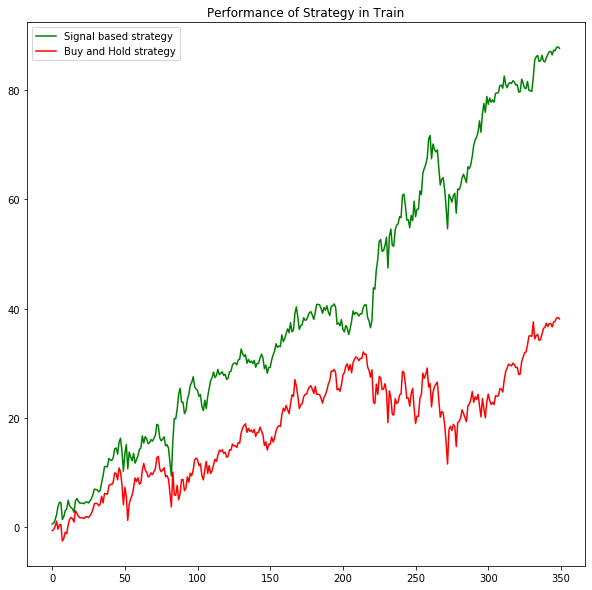

In [17]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(train['msft'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [18]:
#Test Results
test['Order'] = [1 if sig>0 else -1 for sig in test['predictY']]
test['Profit'] = test['msft'] * test['Order']

test['Wealth'] = test['Profit'].cumsum()
print('Total profit made in Test: ', test['Profit'].sum())

Total profit made in Test:  201.75948333740234


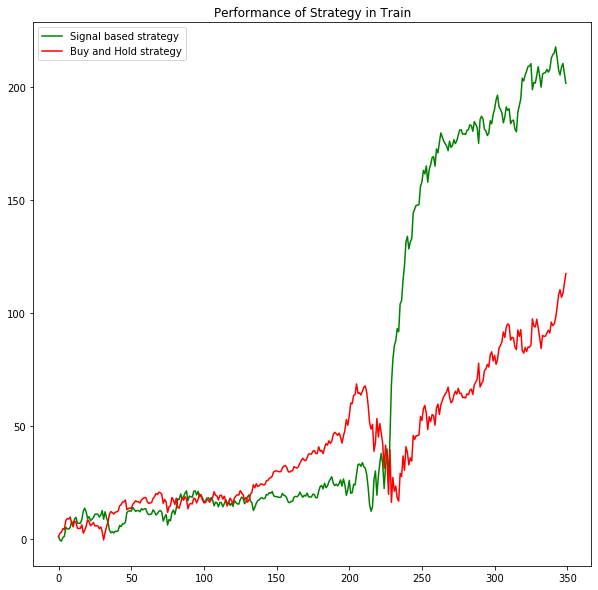

In [19]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(test['msft'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [20]:
#Model Evaluation - Sharpe Ratio and Maximum Drowdown
train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'price_msft']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'price_msft']

In [21]:
train.head()

,msft,sp500,msft_lag1,price_msft,predictY,yhat,Order,Profit,Wealth
Date,,,,,,,,,
2017-11-21,-0.586205,16.890137,1.143616,80.456261,-0.069194,-0.069194,-1,0.586205,81.042465
2017-11-22,0.144135,-1.949951,-0.586205,79.870056,0.237112,0.237112,1,0.144135,81.186600
2017-11-24,0.586227,5.339844,0.144135,80.014191,0.107172,0.107172,1,0.586227,81.772827
2017-11-27,0.970619,-1.000000,0.586227,80.600418,0.018545,0.018545,1,0.970619,82.743446
2017-11-28,-1.479965,25.620117,0.970619,81.571037,-0.028719,-0.028719,-1,1.479965,84.223412


In [22]:
# Sharpe Ratio Data on train
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
dailyr = train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.15390003765428498
Yearly Sharpe Ratio is  2.443087358380286


In [23]:
# Sharpe Ratio in Test data
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
dailyr = test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.13705214883456449
Yearly Sharpe Ratio is  2.1756354147796104


In [24]:
# Maximum Drawdown in Train data
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak'] - train['Wealth'])/train['Peak']
print('Maximum Drawdown in Train is ', train['Drawdown'].max())

Maximum Drawdown in Train is  0.11231236480192476


In [25]:
# Maximum Drawdown in Test data
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak'] - test['Wealth'])/test['Peak']
print('Maximum Drawdown in Test is ', test['Drawdown'].max())

Maximum Drawdown in Test is  0.14133216194837694
